In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/Covid19AI"

/content/drive/My Drive/Covid19AI


In [3]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/BEASF.py" .

In [4]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/visualization_tools.py" .

In [5]:
!pip3 install lime

In [6]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, copy, tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skimage.filters import rank
from skimage.morphology import disk

from BEASF import BEASF
from visualization_tools import GradCAM

# read Data and convert to npy

In [7]:
def get_images(img_path):
  normal_images = list()
  cap_images = list()
  covid_images = list()
  for img_name in glob.glob(pathname=img_path + '/*'):
    img = load_img(path=img_name, color_mode='grayscale')
    img = img_to_array(img=img, data_format='channels_last')
    if 'COVID' in img_name:
      covid_images.append(img)
    elif 'pneumonia' in img_name:
      cap_images.append(img)
    elif 'normal' in img_name:
      normal_images.append(img)
  normal_images = np.array(normal_images)
  cap_images = np.array(normal_images)
  covid_images = np.array(normal_images)

  normal_labels = [0 for _ in range(len(normal_images))]
  cap_labels = [1 for _ in range(len(cap_images))]
  covid_labels = [2 for _ in range(len(covid_images))]

  X = np.concatenate((covid_images, cap_images, normal_images))
  y = np.array(covid_labels + cap_labels + normal_labels)
  return X,y

In [8]:
def resize_images_of(X):
    X = np.array([cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in X])
    X = np.array([np.expand_dims(a=image, axis=-1) for image in X])
    X = X.astype(dtype=np.uint8)
    return X


def show_random_image_from(X):
    rnd_idx = np.random.choice(a=len(X), size=None)
    plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(label='a random image from the dataset')
    plt.show()


def save_dataset(data, labels):
    print('number of total dataset images:', len(data))
    print('number of total dataset labels:', len(labels))
    print('dataset shape:', data.shape)
    print("export images as npy file? (y/n) : default = n need to remove commented code if needed to export")
    """if input() == 'y':
        np.save('./covid_cxr_dataset/cxr_samples.npy', arr=data)
        np.save('./covid_cxr_dataset/cxr_labels.npy', arr=labels)
    else:
        print('dataset exportation aborted.')"""
    print('saved as ./covid_cxr_dataset/cxr_samples.npy')
    print('saved as ./covid_cxr_dataset/cxr_labels.npy')

In [9]:
!ls

 0.Model_flow.ipynb	      Jupyter_notebooks
 1.Image_segmentation.ipynb   Pretrained_Model
 2.Training_model.ipynb      'Projects progress.gdoc'
 Additional		      __pycache__
 BEASF.py		      tmp.h5
 covid_cxr_dataset	     'v1.0_eps=099_valAcc=0.9672.hdf5'
 Documents		      visualization_tools.py


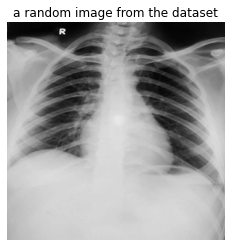

number of total dataset images: 30
number of total dataset labels: 30
dataset shape: (30, 320, 320, 1)
export images as npy file? (y/n)
n
dataset exportation aborted.
saved as ./covid_cxr_dataset/cxr_samples.npy
saved as ./covid_cxr_dataset/cxr_labels.npy


In [10]:
data_path = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/test'

X,y = get_images(img_path=data_path)
X = resize_images_of(X=X)
show_random_image_from(X=X)
save_dataset(data=X, labels=y)

# Dataset loading

number of total dataset images: 748
number of total dataset labels: 748
dataset shape: (748, 320, 320, 1)


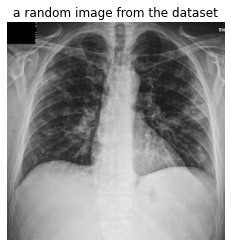

In [11]:
X = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/cxr_samples.npy')
y = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/cxr_labels.npy')

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

In [12]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

segmentor = unet(input_size=(320, 320, 1))
# segmentor.summary()
segmentor.load_weights('/content/drive/My Drive/Covid19AI/Pretrained_Model/cxr_reg_weights.hdf5')

In [13]:
def do_segmentation(images, disk_rad=40, kernel_size=(5, 5), num_iter=3, margin=0):
    equ_images = [rank.equalize(image.squeeze(), selem=disk(radius=disk_rad)) for image in images]
    masks = [segmentor(np.expand_dims(equ_image, axis=[0, -1])) for equ_image in equ_images]
    masks = [cv2.dilate(np.squeeze(mask), kernel=np.ones(kernel_size), iterations=num_iter) for mask in masks]
    images = [image[np.min(np.where(masks[idx]==1)[0]) - margin:np.max(np.where(masks[idx]==1)[0]) + margin, 
                    np.min(np.where(masks[idx]==1)[1]) - margin:np.max(np.where(masks[idx]==1)[1]) + margin]
              for idx, image in enumerate(images)]
    images = [cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in images]
    images = [np.expand_dims(image, axis=-1) for image in images]
    return np.array(images)

In [14]:
%%time
X_segmented = do_segmentation(images=X)

CPU times: user 49.5 s, sys: 1.24 s, total: 50.8 s
Wall time: 50.8 s


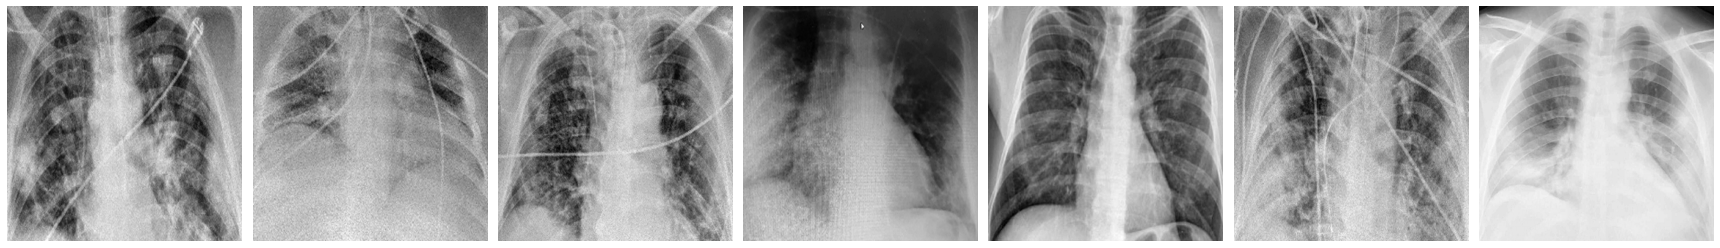

In [15]:
fig = plt.figure(num=7, figsize=(24, 8))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow(X_segmented[np.random.randint(0, len(X_segmented))].squeeze(), cmap='gray')
    plt.axis('off')
fig.tight_layout()
plt.show()

# save the ROI-segmented dataset as npy file
np.save(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/cxr_segmented.npy',
        arr=X_segmented)
np.save(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/cxr_ylabel.npy',
        arr=y)

# Segmentation is completed and saved as **cxr_segmented.npy**



